In [16]:
# Importing libs
import pandas as pd
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder
from jinja2 import Template

from IPython.display import display, Markdown

In [17]:
# Open dataset

data = pd.read_csv('../estaticos_market.csv', index_col=0)

In [18]:
# Removing rows where 'de_ramo' == 'OUTROS' to get some full-filled columns for testing

data = data.loc[data['de_ramo'] != 'OUTROS']

data.shape

(460371, 181)

In [19]:
# Removing columns where exists NaNs

removed_columns = []
for col in data.iloc[:, 1:]:
    if data[col].isna().sum() != 0:
        removed_columns.append(col)

new_columns = list(set(data.columns) - set(removed_columns))
data = data.loc[:, new_columns]

data.shape

(460371, 28)

In [20]:
data.columns

Index(['fl_email', 'idade_empresa_anos', 'fl_mei', 'fl_st_especial', 'fl_me',
       'vl_total_veiculos_leves_grupo', 'fl_veiculo', 'fl_simples_irregular',
       'nm_divisao', 'fl_ltda', 'de_natureza_juridica', 'idade_emp_cat',
       'sg_uf', 'natureza_juridica_macro', 'qt_filiais', 'fl_sa', 'fl_spa',
       'vl_total_veiculos_pesados_grupo', 'fl_telefone', 'nm_segmento',
       'de_ramo', 'fl_matriz', 'fl_passivel_iss', 'id', 'fl_epp', 'fl_antt',
       'fl_rm', 'setor'],
      dtype='object')

In [21]:
with open('dict.json') as f:
    vars_dict = json.load(f)

for col in data:
    if col == 'id':
        continue
    print(f'{col} -> {vars_dict[col]}')

fl_email -> boolean value, true if the cnpj has an email registered at the IRF database.
idade_empresa_anos -> numeric value, age of the company.
fl_mei -> boolean value, true if the company has the term 'MEI' in the end of its legal name.
fl_st_especial -> boolean value, true if dt_situacao_especial is not null. If it is not null means that some extraordinary situation is identified by the IRS (ESPOLIO DE EMPRESARIO EMPRESA INDIVIDUAL OU EIRELI, FALIDO, EM LIQUIDACAO, LIQUIDACAO JUDICIAL, LIQUIDACAO EXTRA JUDICIAL, REGISTRO NA JUNTA COMERCIAL EM ANDAMENTO, EM LIQUID EXTRA JUDICIAL, RECUPERACAO JUDICIAL, INTERVENCAO)
fl_me -> boolean value, true if the company has the term 'ME' in the end of its legal name.
vl_total_veiculos_leves_grupo -> numeric, economic value of the light weight vehicles of the economic group of the company
fl_veiculo -> boolean, true if the company owns at least one vehicle
fl_simples_irregular -> boolean, true if the company is taxed under the SIMPLES regime and 

In [22]:
# Removing features by its description
cols_to_remove = [
    'fl_telefone', # Se tem número de telefone registrado no db. Acho que da de tirar
]

data = data.loc[:, set(data.columns) - set(cols_to_remove)]

data.shape

(460371, 27)

In [23]:
# Make the index as the 'id' columns

data.set_index('id', inplace=True)

data.shape

(460371, 26)

In [24]:
data.dtypes

fl_email                              bool
sg_uf                               object
natureza_juridica_macro             object
qt_filiais                           int64
fl_sa                                 bool
idade_empresa_anos                 float64
fl_spa                              object
fl_mei                                bool
vl_total_veiculos_pesados_grupo    float64
fl_st_especial                        bool
nm_segmento                         object
de_ramo                             object
fl_matriz                             bool
fl_me                                 bool
fl_passivel_iss                     object
vl_total_veiculos_leves_grupo      float64
fl_veiculo                          object
fl_simples_irregular                object
fl_epp                                bool
fl_antt                             object
fl_rm                               object
nm_divisao                          object
fl_ltda                               bool
de_natureza

In [25]:
# Fix True/False objects
data['fl_passivel_iss'] = data['fl_passivel_iss'].astype('bool')
data['fl_antt'] = data['fl_antt'].astype('bool')
data['fl_spa'] = data['fl_spa'].astype('bool')
data['fl_simples_irregular'] = data['fl_simples_irregular'].astype('bool')
data['fl_veiculo'] = data['fl_veiculo'].astype('bool')

for col in data:
    

data.dtypes

fl_email                              bool
sg_uf                               object
natureza_juridica_macro             object
qt_filiais                           int64
fl_sa                                 bool
idade_empresa_anos                 float64
fl_spa                                bool
fl_mei                                bool
vl_total_veiculos_pesados_grupo    float64
fl_st_especial                        bool
nm_segmento                         object
de_ramo                             object
fl_matriz                             bool
fl_me                                 bool
fl_passivel_iss                       bool
vl_total_veiculos_leves_grupo      float64
fl_veiculo                            bool
fl_simples_irregular                  bool
fl_epp                                bool
fl_antt                               bool
fl_rm                               object
nm_divisao                          object
fl_ltda                               bool
de_natureza

In [26]:
# Generating dummies for the categorical features, one hot encoding

new_dfs = []
to_remove_cols = []
for col in data:
    if data[col].dtype == np.object:
        to_remove_cols.append(col)
        dummies = pd.get_dummies(data[col], prefix=col)
        new_dfs.append(dummies)

data = data.loc[:, list(set(data.columns) - set(to_remove_cols))]
        
for d in new_dfs:
    data = data.join(d)

data.columns

Index(['vl_total_veiculos_pesados_grupo', 'fl_st_especial', 'fl_email',
       'fl_matriz', 'fl_me', 'fl_passivel_iss',
       'vl_total_veiculos_leves_grupo', 'fl_veiculo', 'fl_simples_irregular',
       'qt_filiais',
       ...
       'setor_COMERCIO', 'setor_CONSTRUÇÃO CIVIL', 'setor_INDUSTRIA',
       'setor_SERVIÇO', 'idade_emp_cat_1 a 5', 'idade_emp_cat_10 a 15',
       'idade_emp_cat_15 a 20', 'idade_emp_cat_5 a 10', 'idade_emp_cat_<= 1',
       'idade_emp_cat_> 20'],
      dtype='object', length=249)

In [27]:
data.shape

(460371, 249)

In [28]:
# Load clients of portifólio1

portfilio1 = pd.read_csv('../estaticos_portfolio1.csv', index_col=0)

In [42]:
clients_p1_data = data.loc[portfilio1['id']]

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

train, test = train_test_split(clients_p1_data, test_size=0.2)

# Making the user profile
u = dict()
for col in train:
    u[col] = clients_p1_data[col].mean()
    
user = pd.DataFrame([u])

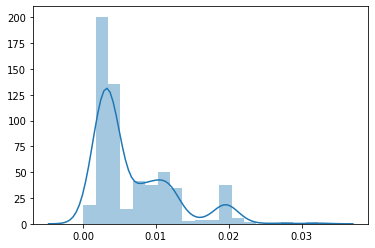

In [92]:
similarities = pd.DataFrame(data=cosine_similarity(train, user), columns=['Similarity'])

similarities.set_index(train.index, inplace=True)

sns.distplot(similarities)